Labels: tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


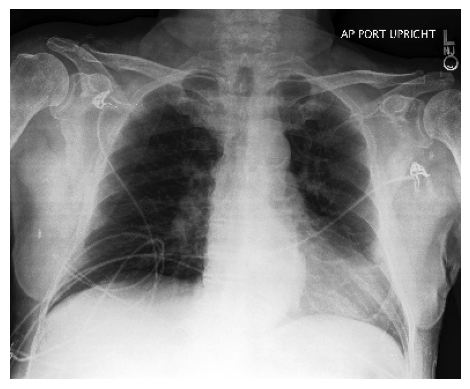

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])


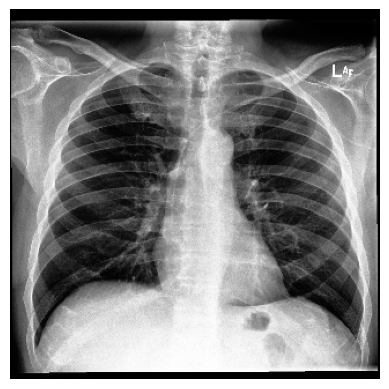

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])


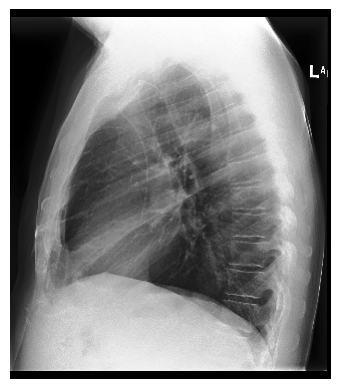

Batch length: 2
Type of element 0: <class 'dict'>
Keys in element 0: dict_keys(['image', 'label', 'sample_idx', 'RandomResizedCrop', 'RandomHorizontalFlip', 'ColorJitter', 'RandomGrayscale'])
Label type: <class 'torch.Tensor'>
Label dtype: torch.int64
Label shape: torch.Size([256, 14])


In [16]:
"""
Path to dataset files: /users/yliu802/.cache/kagglehub/datasets/ashery/chexpert/versions/1

Folder structure:
    train/
        patient0001/study1/view1_frontal.jpg
        patient0001/study1/view2_lateral.jpg
    valid/
        ...
CSV columns (train_split.csv / val_split.csv):
    Path, Sex, Age, Frontal/Lateral, AP/PA,
    Enlarged Cardiomediastinum, Cardiomegaly, Lung Opacity, Lung Lesion,
    Edema, Consolidation, Pneumonia, Atelectasis, Pneumothorax,
    Pleural Effusion, Pleural Other, Fracture, Support Devices, No Finding
"""

import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import torch
import matplotlib.pyplot as plt

import stable_pretraining as spt
from stable_pretraining.data import transforms


class ChestXrayDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None,
                 with_labels=True, use_no_finding=True):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.with_labels = with_labels

        # Label columns
        self.label_cols = [
            "Enlarged Cardiomediastinum",
            "Cardiomegaly",
            "Lung Opacity",
            "Lung Lesion",
            "Edema",
            "Consolidation",
            "Pneumonia",
            "Atelectasis",
            "Pneumothorax",
            "Pleural Effusion",
            "Pleural Other",
            "Fracture",
            "Support Devices",
            "No Finding",
        ]
        if not use_no_finding:
            self.label_cols.remove("No Finding")

        # Ensure labels are numeric float (this fixes the numpy.object_ / TypeError)
        self.df[self.label_cols] = self.df[self.label_cols].apply(
            pd.to_numeric, errors="coerce"
        )
        # Optional: if any NaNs creep in, treat them as 0
        self.df[self.label_cols] = self.df[self.label_cols].fillna(0.0)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # CSV: "patient64541/study1/view1_frontal.jpg"
        # root_dir: ".../train" or ".../valid"
        img_path = os.path.join(self.root_dir, row["Path"])
        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        if not self.with_labels:
            return image

        # Series -> numpy float32 -> tensor [num_labels]
        labels_np = row[self.label_cols].to_numpy(dtype="int64")
        labels = torch.from_numpy(labels_np)

        return image, labels


# ---------------- Basic sanity check on the raw dataset ----------------

train_ds = ChestXrayDataset(
    csv_file="train_split.csv",
    root_dir="/users/yliu802/.cache/kagglehub/datasets/ashery/chexpert/versions/1/train",
    transform=None,          # raw PIL for now
    with_labels=True,
)

val_ds = ChestXrayDataset(
    csv_file="val_split.csv",
    root_dir="/users/yliu802/.cache/kagglehub/datasets/ashery/chexpert/versions/1/valid",
    transform=None,
    with_labels=True,
)

# Quick visual check
for i in range(3):
    img, labels = val_ds[i]
    plt.imshow(img)
    plt.axis("off")
    print("Labels:", labels)
    plt.show()


# ---------------- SSL transforms + FromTorchDataset wrapper ----------------

# MoCo-style multi-view transform: 2 crops / views
moco_transform = transforms.MultiViewTransform(
    [
        transforms.Compose(
            transforms.RGB(),
            transforms.RandomResizedCrop((224, 224), scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(
                brightness=0.4,
                contrast=0.4,
                saturation=0.2,
                hue=0.1,
                p=0.8,
            ),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToImage(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
            ),
        ),
        transforms.Compose(
            transforms.RGB(),
            transforms.RandomResizedCrop((224, 224), scale=(0.08, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(
                brightness=0.4,
                contrast=0.4,
                saturation=0.2,
                hue=0.1,
                p=0.8,
            ),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomSolarize(threshold=0.5, p=0.2),
            transforms.ToImage(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
            ),
        ),
    ]
)

# Wrap the torch Dataset so stable_pretraining can see "image" and "label"
train_dataset = spt.data.FromTorchDataset(
    train_ds,
    names=["image", "label"],   # (image, labels) -> dict["image"], dict["label"]
    transform=moco_transform,   # applied on "image"
)

val_dataset = spt.data.FromTorchDataset(
    val_ds,
    names=["image", "label"],
    transform=transforms.Compose(
        transforms.RGB(),
        transforms.Resize((224, 224)),
        transforms.ToImage(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
        ),
    ),
)

# ---------------- Dataloaders ----------------

train_dataloader = DataLoader(
    dataset=train_dataset,
    sampler=spt.data.sampler.RepeatedRandomSampler(train_dataset, n_views=2),
    batch_size=256,
    num_workers=8,
    drop_last=True,
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=256,
    num_workers=8,
)

# If it’s a list of tuples, unpack it
# Inspect one batch from the dataloader
batch = next(iter(train_dataloader))

if isinstance(batch, (list, tuple)):
    print("Batch length:", len(batch))

    b0 = batch[0]
    print("Type of element 0:", type(b0))

    if isinstance(b0, dict):
        print("Keys in element 0:", b0.keys())

        # Check label dtype and shape
        lbl = b0["label"]
        print("Label type:", type(lbl))
        if isinstance(lbl, torch.Tensor):
            print("Label dtype:", lbl.dtype)
            print("Label shape:", lbl.shape)
        else:
            print("Label value:", lbl)
    else:
        print("Element 0:", b0)
else:
    print("Batch type:", type(batch))
    print("Batch content:", batch)

In [14]:
import lightning as pl
import torch
import torchmetrics
import torchvision
from torch import nn
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint

import stable_pretraining as spt
from stable_pretraining.data import transforms

# Define augmentations for SimCLR (creates 2 views of each image)
simclr_transform = transforms.MultiViewTransform(
    [
        transforms.Compose(
            transforms.RGB(),
            transforms.RandomResizedCrop((224, 224), scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1, p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToImage(**spt.data.static.CIFAR10),
        ),
        # Second view with slightly different augmentations
        transforms.Compose(
            transforms.RGB(),
            transforms.RandomResizedCrop((224, 224), scale=(0.08, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1, p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomSolarize(threshold=0.5, p=0.2),
            transforms.ToImage(**spt.data.static.CIFAR10),
        ),
    ]
)

# Load CIFAR-10 and wrap in dictionary format
cifar_train = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)
cifar_val = torchvision.datasets.CIFAR10(root="./data", train=False, download=True)

train_dataset = spt.data.FromTorchDataset(
    cifar_train,
    names=["image", "label"],  # Convert tuple to dictionary
    transform=simclr_transform,
)

val_dataset = spt.data.FromTorchDataset(
    cifar_val,
    names=["image", "label"],
    transform=transforms.Compose(
        transforms.RGB(),
        transforms.Resize((224, 224)),
        transforms.ToImage(**spt.data.static.CIFAR10),
    ),
)

# Create dataloaders with view sampling for contrastive learning
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    sampler=spt.data.sampler.RepeatedRandomSampler(train_dataset, n_views=2),
    batch_size=256,
    num_workers=8,
    drop_last=True,
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=256,
    num_workers=10,
)

# If it’s a list of tuples, unpack it
# Inspect one batch from the dataloader
batch = next(iter(train_dataloader))

if isinstance(batch, (list, tuple)):
    print("Batch length:", len(batch))

    b0 = batch[0]
    print("Type of element 0:", type(b0))

    if isinstance(b0, dict):
        print("Keys in element 0:", b0.keys())

        # Check label dtype and shape
        lbl = b0["label"]
        print("Label type:", type(lbl))
        if isinstance(lbl, torch.Tensor):
            print("Label dtype:", lbl.dtype)
            print("Label shape:", lbl.shape)
        else:
            print("Label value:", lbl)
    else:
        print("Element 0:", b0)
else:
    print("Batch type:", type(batch))
    print("Batch content:", batch)


Batch length: 2
Type of element 0: <class 'dict'>
Keys in element 0: dict_keys(['image', 'label', 'sample_idx', 'RandomResizedCrop', 'RandomHorizontalFlip', 'ColorJitter', 'RandomGrayscale'])
Label type: <class 'torch.Tensor'>
Label dtype: torch.int64
Label shape: torch.Size([256])
